In [1]:
#0. calling module
import tensorflow as tf
import numpy as np

tf 2.0 부터는 session방식보다 eager 방식을 쓰는 것을 권장한다고 한다. 그래서 tf.enable_eager_execution()을 써 주어야 한다고 한다. -> 공부가 필요

In [2]:
#1. parameter setting
#optimization - Stochastic Gradient Descent
#𝑣𝑖+1=0.9𝑣𝑖−0.0005𝜖𝑤𝑖−𝜖∂𝐿/∂𝑤𝑖

batch_size = 128
momentum = 0.9
weight_decay = 0.0005
learning_rate =0.01

In [3]:

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer

In [4]:
#2. build Local response normalization(LRN)
class LocalResponseNormalization(Layer):

    def __init__(self, n=5, alpha=1e-4, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x):
        _, r, c, f = self.shape 
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1,1), padding="same", pool_mode='avg')
        summed = K.sum(pooled, axis=3, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom 
    
    def compute_output_shape(self, input_shape):
        return input_shape 

스크린샷 2020-03-16 오후 11.05.42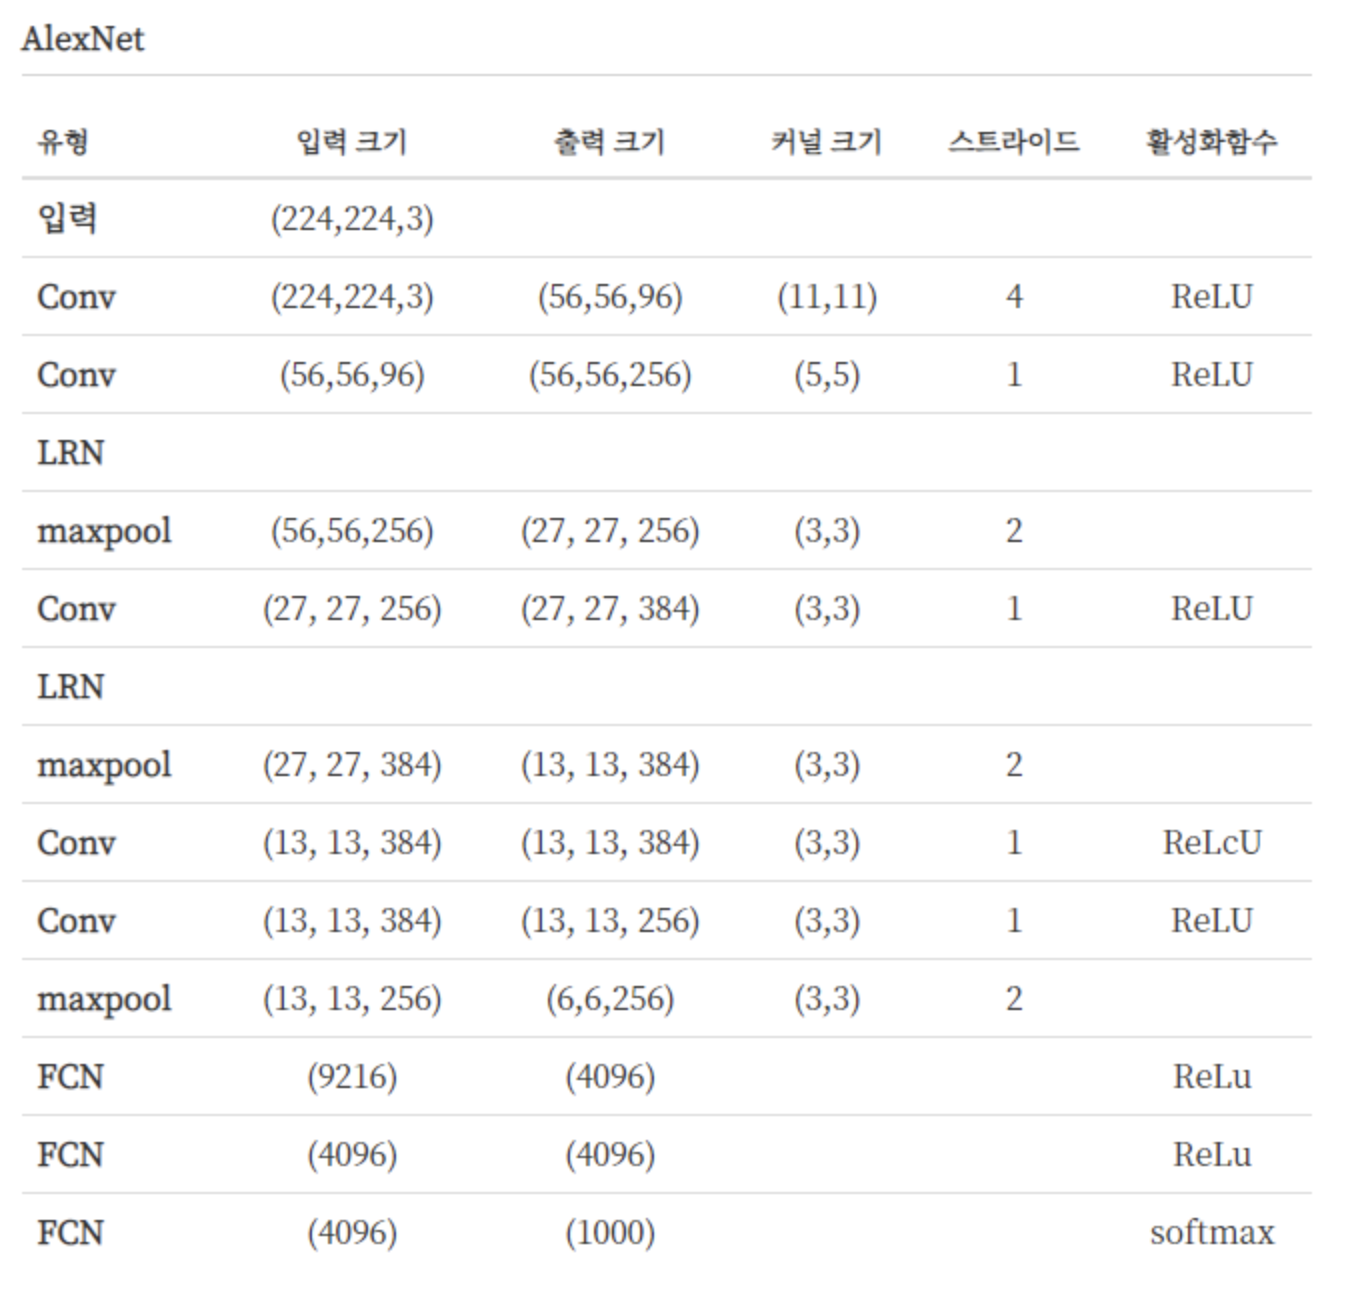

In [25]:
#3. build model- AlexNet

class AlexNet(tf.keras.Model):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.sequence = list()
        
        self.sequence.append(Conv2D(96, (11, 11), strides = 4, padding = 'same', input_shape = input_shape ))
        self.sequence.append(Conv2D(256, (5, 5), strides = 1, activation = 'relu', padding = 'same'))
        self.sequence.append(LocalResponseNormalization(input_shape = self.sequence.output_shape[1:]))
        self.sequence.append(MaxPool2D((3, 3), strides = 2))
        
        self.sequence.append(Conv2D(384, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
        self.sequence.append(Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
        self.sequence.append(MaxPool2D((3, 3), strides = 2))

        self.sequence.append(Flatten()) #6*6*256
        self.sequence.append(Dense(4096, activation = 'relu'))
        self.sequence.append(Dropout(0.5))
        
        self.sequence.append(Dense(4096, activation = 'relu'))
        self.sequence.append(Dropout(0.5))
        
        self.sequence.append(Dense(10, activation = 'softmax'))
        
    def call(self, x, training = False, mask = None):
        for layer in self.sequence:
            x = layer(x)
        return x
    

In [12]:
#3. Training function
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape: #tf.GradientTape을 사용하여 그래디언트를 계산합니다.
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    

In [13]:
#4. Test function
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images)
    
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [22]:
#4. Prepare Dataset : keras에서 제공하는 cifar10 dataset 사용

#call data
#cifar = tf.keras.datasets.cifar10
#(X_train, y_train), (X_test, y_test) = cifar.load_data()

#call data
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#normalization
X_train, X_test = X_train/255.0, X_test/255.0

#num_sample, height, width -> num_sample, height, width, channel in
X_train = X_train[..., tf.newaxis].astype(np.float32)
X_test = X_test[..., tf.newaxis].astype(np.float32)

#dataset 만들기
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [23]:
X_train.shape

(60000, 28, 28, 1)

In [26]:
#5. Define the training environment

#create model
input_shape = (28, 28, 1)
model = AlexNet()

#Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

#Define performance metrics
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

AttributeError: 'ListWrapper' object has no attribute 'output_shape'

In [ ]:
#테스트 이미지 Augmentation 즉 그 이미지의 상/하/좌/우/원본 , 이들의 각각의 반전 까지 해서 총 10개의 데이터에서
#예측치의 평균 사용

In [ ]:
#성능 평가

optimizer = optimizers.SGD(learning_rate=learning_rate, decay=weight_decay, momentum=momentum)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
model.summary()